This notebook can be used to explore the dataset of policy documents with some prepared text mining/natural language procesing algorithms.

It expects that a data frame has been produced by either the default pipeline or a custom analysis pipeline.

Click on a cell and execute it with 'Shift + Enter' or 'Strg + Enter'.

In [2]:
import pandas as pd

The next cell reads in the preprocessed dataframe (after the default pipeline has run). Point the path to the location of the 'test.pkl' file.

In [3]:
df = pd.read_pickle("results/test.pkl")

The next cell displays the columns in the dataframe.

In [4]:
df.columns

Index(['availableLanguages', 'category', 'classification', 'fulltext',
       'identifier', 'keywords', 'lastUpdateDate', 'links', 'publicationDate',
       'referenceDocument', 'relatedProject', 'title', 'typesOfAction',
       'links2', 'entities', 'title_mentions', 'identifier_mentions', 'cites',
       'targets'],
      dtype='object')

The next cell counts the missing or Null values per column.

In [5]:
for col in df.columns:
    nancount = len(df[df[col].isnull()])
    print("%d Null values in %s." %(nancount, col))

51 Null values in availableLanguages.
51 Null values in category.
0 Null values in classification.
0 Null values in fulltext.
45 Null values in identifier.
51 Null values in keywords.
51 Null values in lastUpdateDate.
0 Null values in links.
45 Null values in publicationDate.
51 Null values in referenceDocument.
97 Null values in relatedProject.
0 Null values in title.
106 Null values in typesOfAction.
0 Null values in links2.
0 Null values in entities.
0 Null values in title_mentions.
0 Null values in identifier_mentions.
0 Null values in cites.
0 Null values in targets.


In [38]:
# Importing libraries for natural language processing
from gensim import corpora
from gensim import corpora, models, similarities
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.text import Text
from itertools import chain

In [7]:
stop_en = stopwords.words('english')

Additional stopwords can simply be added by filling in the list in the following cell, e.g.:

`stop_en.extend(["extra_stopword1", "extra_stopword2"])`

In [8]:
stop_en.extend([])

In [9]:
stop_en

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

The next two cells extract the fulltext contents from the dataframe and prepare it for the text analysis.

In [12]:
# get a list of all fulltexts from the dataframe
fulltexts = df['fulltext']
fulltexts = [" ".join(ft) for ft in fulltexts]

In [13]:
# remove multiple linebreaks from fulltexts, this helps cleaning up artifacts from pdf extraction
fulltexts = [ft.replace('\n  \n', '\n') for ft in fulltexts]
fulltexts = [ft.replace('\n \n', '\n') for ft in fulltexts]
fulltexts = [ft.replace('\n\n', '\n') for ft in fulltexts]
fulltexts = [ft.replace('\n', ' ') for ft in fulltexts]

The next cell makes a concordance analysis of a keyword, that can defined in the first line. Unfortunately, NLTK currently offers no support for multi-word concordance.

In [77]:
keyword = "science"

def get_all_phases_containing_tar_wrd(target_word, text, left_margin = 10, right_margin = 10):
    """
    FROM: https://simply-python.com/2014/03/14/saving-output-of-nltk-text-concordance/
    
        Function to get all the phases that contain the target word in a text/passage tar_passage.
        Workaround to save the output given by nltk Concordance function
         
        str target_word, str tar_passage int left_margin int right_margin --> list of str
        left_margin and right_margin allocate the number of words/pununciation before and after target word
        Left margin will take note of the beginning of the text
    """
    tokens = nltk.word_tokenize(text)
    text = nltk.Text(tokens)
    c = nltk.ConcordanceIndex(text.tokens, key = lambda s: s.lower())
    concordance_txt = ([text.tokens[map(lambda x: x-5 if (x-left_margin)>0 else 0,[offset])[0]:offset+right_margin]
                        for offset in c.offsets(target_word)])
    result = [''.join([x+' ' for x in con_sub]) for con_sub in concordance_txt]
    return result


results = get_all_phases_containing_tar_wrd(keyword, fulltexts[0])

TypeError: 'map' object is not subscriptable

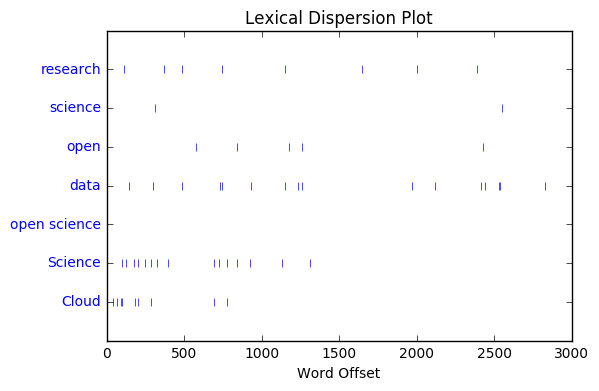

In [98]:
text.dispersion_plot(["research", "science", "open", "data", "open science", "Science", "Cloud"])

In [20]:
# lowercase and tokenize texts, returns a list of tokens (words) per fulltext
texts = [[word for word in nltk.wordpunct_tokenize(document.lower()) if word not in stop_en] for document in fulltexts]

In [23]:
# remove all tokens that appear only once in the whole corpus
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 1] for text in texts]

In [24]:
# create a dictionary over all texts (ID to str map)
dictionary = corpora.Dictionary(texts)

In [25]:
# create a corpus by mapping all tokens to their IDs
corpus = [dictionary.doc2bow(text) for text in texts]

In [26]:
# create a Term Frequency - Inverse Document Frequency model of the corpus
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [31]:
# create an Latent Semantic Analysis (dimensionality reduction) model over the TF-IDF corpus
# vary the num_topics parameter
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=10)
corpus_lsi = lsi[corpus_tfidf]
lsi.show_topics(num_words=10, formatted=False)

[(0,
  [('\uf0b7', -0.13126052013077597),
   ('.', -0.12462082921383288),
   (',', -0.11985459460860363),
   ('data', -0.10288781968707131),
   ('horizon', -0.10146479199789606),
   ('/', -0.10145454974097236),
   ('2020', -0.10135921124084254),
   ('proposals', -0.10036331252236239),
   ('infrastructures', -0.096603621379800539),
   ('proposal', -0.096594014436754916)]),
 (1,
  [('macumba', -0.57531005627455789),
   ('marine', -0.22720120006666888),
   ('macumbaproject', -0.21782464808876306),
   ('marieke', -0.21560031347444025),
   ('aquatt', -0.19523377957400453),
   ('microorganisms', -0.16555206412545889),
   ('cultivation', -0.13343474407835504),
   ('event', -0.11924132053192454),
   ('facebook', -0.11322741468755125),
   ('reuver', -0.11271105379290404)]),
 (2,
  [('\uf0b7', -0.27679017063958128),
   ('data', 0.14045364462342363),
   ('macumba', -0.13263725954595929),
   ('cloud', 0.12630168320046431),
   ('\uf02d', -0.12304616448136178),
   ('eloise', 0.11381576148086849),
  

In [33]:
# create an Latent Dirichlet Allocation model over the TF-IDF corpus
# (probabilistic distributions of words over topics, and of topics over documents) 
# vary the num_topics parameter
train_corpus = corpus_tfidf[:-20]
test_corpus = corpus_tfidf[-20:]
for k in [2, 5, 10, 15, 20]:
    lda = models.LdaModel(train_corpus, num_topics=k, id2word=dictionary)
    corpus_lda = lda[corpus_tfidf]
    #lda.show_topics(num_words=10, formatted=False)
    print(lda.log_perplexity(test_corpus))

-348.751590666
-311.190748096
-286.283611344
-274.865774027
-268.212354255


In [35]:
from itertools import chain

In [36]:
# split each fulltext into sentences, word tokenize each sentence
sentences = list(chain.from_iterable([sent_tokenize(ft) for ft in fulltexts]))
sentences = [word_tokenize(s) for s in sentences]

In [99]:
bigram_transformer = models.Phrases(sentences, min_count=3)

NameError: name 'sentences' is not defined

In [39]:
# create a word2vec model based on sentence, positioning words in a vector space
w2vModel = models.Word2Vec(bigram_transformer[sentences], size=100, window=5, min_count=3, workers=4, iter=50, sg=1)

/home/chris/anaconda3/envs/masso/lib/python3.5/site-packages/gensim/models/phrases.py:248: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


The word2vec model can be used to look for words that are possible synonyms, or appear in a very similar context.

In [40]:
w2vModel.most_similar_cosmul(topn=20, positive=['open_science'])

[('industry_conference', 0.7805285453796387),
 ('debates', 0.7726726531982422),
 ('While_some', 0.7689239978790283),
 ('Will', 0.76511150598526),
 ('two-day', 0.7640762329101562),
 ('presentations', 0.7594132423400879),
 ('data-driven', 0.7590374946594238),
 ('audience', 0.7581926584243774),
 ('RRI', 0.7555072903633118),
 ('meeting', 0.7529993653297424),
 ('ELOISE', 0.7508211135864258),
 ('motivation', 0.7496086359024048),
 ('inherently', 0.7488611340522766),
 ('skill', 0.7477912902832031),
 ('ideas', 0.7459557056427002),
 ('schooling', 0.7439967393875122),
 ('formal_technology', 0.7429242730140686),
 ('events', 0.7409762740135193),
 ('exciting', 0.7407679557800293),
 ('MIDAS', 0.7397767901420593)]

In [41]:
w2vModel.n_similarity(['open','science'], ['open','research'])

0.8610271132859918